## Linear Regression

In [105]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd() + "/..")
from utils import plot_correlogram
import feature_engineering as fe
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from utils import combine_data
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')
random_state=123456789
np.random.seed(123456789)
from utils import plot_correlogram, nmae, nmae_scorer, mape_scorer, mean_squared_error_scorer
from typing import Dict
from sklearn.utils import shuffle
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
#models
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope
import hyperopt
import tqdm

#vis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [106]:
meta, data =pd.read_pickle("../data/forecast_data_2020.p")

In [107]:
homes_indexes = data.columns.get_level_values(0).unique()

In [108]:
homes_indexes

Index(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801',
       '987', '299', '640', '744', '241', '200', '441', '192', '621', '313',
       '464', '424', '993', '598', '514', '268', '745', '927', '945', '352',
       '980', '644', '683', '244', '677', '351', '118', '595', '255', '554',
       '318', '743', '947', '480', '219', '780', '909', '977', '272', '246',
       '521', '842', '267', '396', '290', '601', '901', '260', '618', '629',
       '238', '231', '875', '889', '340', '906', '604', '525', '460', '130',
       '363', '250', '666', '438', '986', '462', '188', '763', '923', '925',
       '822', '131', '456', '624', '827', '474', '859', '912', '194', '706',
       '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'],
      dtype='object')

## Feature Engineering

### Target
Since at time step T we need to predict the value given at step T+1, but at step T
we only know values from step T-1 (make prediction on Wednesday about Constumption on Thursday, given known values of consumption only at Teusday, thus we need to shift by 2 * 24h = 48h

In [109]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-48),fe.CastType(float),fe.ApplyLogTransformation())

### Current consumption
consumption at step T-1 won't require any shift

In [110]:
prev_consumption = make_pipeline(fe.FeatureSelector('consumption'), fe.CastType(float), fe.ApplyLogTransformation())

rolling_window = fe.make_union(*(make_pipeline(fe.FeatureSelector('consumption'),fe.CastType(float),fe.ApplyLogTransformation(), fe.ApplyRollingWindowMean(i*24)) for i in range(1,4)))

### Weather

Note all weather prediction for T+1 is given at step T, thus we need to shift for 24h

In [111]:
temperature = make_pipeline(fe.FeatureSelector('temperature'), fe.CalcShift(-48), fe.CastType(float))
humidity = make_pipeline(fe.FeatureSelector('humidity'), fe.CalcShift(-48), fe.CastType(float))
cloudiness = make_pipeline(fe.FeatureSelector('cloudiness'), fe.CalcShift(-48), fe.CastType(float))

### Extract Day Time

In [112]:
day_time =  make_pipeline(fe.FeatureSelector('time'), fe.ExtractDayTime(), fe.OneHot(drop_first=False))

### Extract season name from date

In [113]:
season = make_pipeline(fe.FeatureSelector('time'), fe.ExtractSeason(), fe.OneHot(drop_first=False))

### Combine Features

In [114]:
feature_union = fe.make_union(prev_consumption,
                              # prev_consumption_ago,
                              temperature,
                              humidity,
                              cloudiness,
                              day_time,
                              season,
                              target
                              )
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('casttype', CastType()),
                                                      ('applylogtransformation',
                                                       ApplyLogTransformation())])),
                                     ('pipeline-2',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='temperature')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-48)),
                                                      ('castt...
                                     ('pipeline-6',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='time')),
                                                      ('extractseason',
                                                       ExtractSeason()),
                                                      ('onehot', OneHot())])),
                                     ('pipeline-7',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-48)),
                                                      ('casttype', CastType()),
                                                      ('applylogtransformation',
                                                       ApplyLogTransformation())]))])

## Transform

In [115]:
def create_samples(home_indexes_subsample):
    df_dict = {}
    for home_i in list(home_indexes_subsample):
        if home_i == "268": # outlier
            continue
        temp_df = data[home_i]
        temp_df["time"] = temp_df.index
        temp_df = feature_union.fit_transform(temp_df)
        rolling = rolling_window.fit_transform(data[home_i])
        temp_df = temp_df.merge(rolling, left_index=True, right_index=True, how="inner")
        temp_df = temp_df.reset_index().drop_duplicates(subset='time', keep="last").set_index("time")
        temp_df["ev"] = meta[home_i]["has_electric_vehicle"] +0
        temp_df["home_num"] = home_i

        df_dict[home_i] = temp_df
    return df_dict

#Train data
train_homes_indexes_subsample = np.random.choice(homes_indexes,60,replace =False)
df_dict_train = create_samples(train_homes_indexes_subsample)
df_train = combine_data(df_dict_train)

#Test data
test_homes_indexes_subsample = [i for i in homes_indexes if i not in train_homes_indexes_subsample]
df_dict_test = create_samples(test_homes_indexes_subsample)
df_test = combine_data(create_samples(df_dict_test))

In [116]:
df_train.columns

Index(['consumption', 'forward_temperature_48', 'forward_humidity_48',
       'forward_cloudiness_48', 'day_time_Day Time',
       'day_time_Day Time Peak Hour', 'day_time_Evening', 'day_time_Morning',
       'day_time_Night', 'season_Autumn', 'season_Spring', 'season_Summer',
       'season_Winter', 'forward_consumption_48',
       'rolling_mean_24_consumption', 'rolling_mean_48_consumption',
       'rolling_mean_72_consumption', 'ev', 'home_num'],
      dtype='object')

In [117]:
FEATURES = ['consumption', 'forward_temperature_48', 'forward_humidity_48',
       'forward_cloudiness_48', 'day_time_Day Time',
       'day_time_Day Time Peak Hour', 'day_time_Evening', 'day_time_Morning',
       'day_time_Night', 'season_Autumn', 'season_Spring', 'season_Summer',
       'season_Winter', 'ev','rolling_mean_24_consumption', 'rolling_mean_48_consumption',
       'rolling_mean_72_consumption']
TARGET = 'forward_consumption_48'

In [118]:
# Since we transformed the problem from Time-Series to Tabular, we allowed to shuffle it
df_train = shuffle(df_train)
df_test = shuffle(df_test)
X_train, y_train = df_train[FEATURES], df_train[TARGET]
X_test, y_test = df_test[FEATURES], df_test[TARGET]

In [119]:
print(X_train.shape)

(519960, 17)


In [120]:
print(X_test.shape)

(337974, 17)


## Model Linear Regression

In [121]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

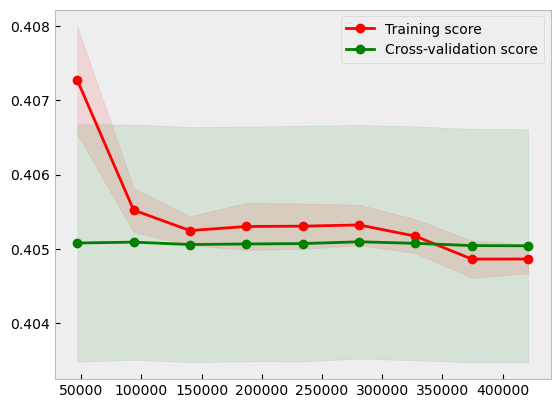

In [122]:
SCORING = nmae_scorer
train_sizes, train_scores, test_scores =learning_curve(model,
                                                       X_train,
                                                       y_train,
                                                       scoring=SCORING,
                                                       train_sizes=np.array([i/10 for i in range(1,10)]),
                                                       cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.grid()
plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
plt.legend(loc="best")

Text(0.5, 1.0, 'Top 40 feature imporance')

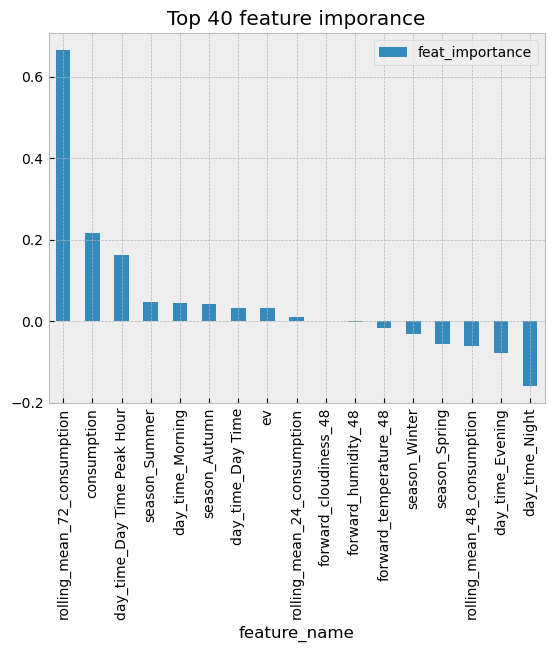

In [123]:
top = 40
df_feat = (
    pd.DataFrame({"feat_importance": model.coef_,
                  "feature_name": X_train.columns})
    .sort_values(by="feat_importance", ascending=False)
          )
df_feat.head(top).plot.bar(x="feature_name", y ="feat_importance")
plt.title(f"Top {top} feature imporance")

## Model Prediction on Individual House Train

In [124]:
df_dict_train.keys()

dict_keys(['246', '859', '618', '987', '744', '404', '464', '241', '743', '854', '598', '255', '299', '993', '222', '424', '412', '677', '260', '906', '290', '583', '604', '644', '980', '340', '123', '244', '192', '219', '890', '118', '875', '621', '131', '460', '480', '484', '363', '657', '595', '313', '666', '188', '957', '947', '763', '554', '780', '438', '822', '927', '250', '272', '600', '852', '267', '999', '629', '514'])

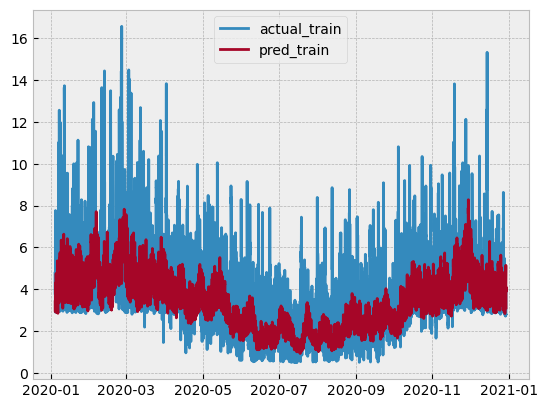

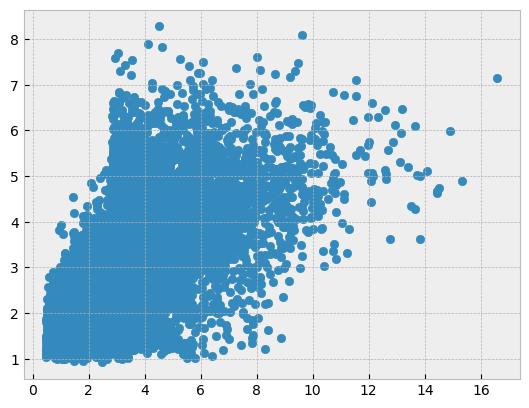

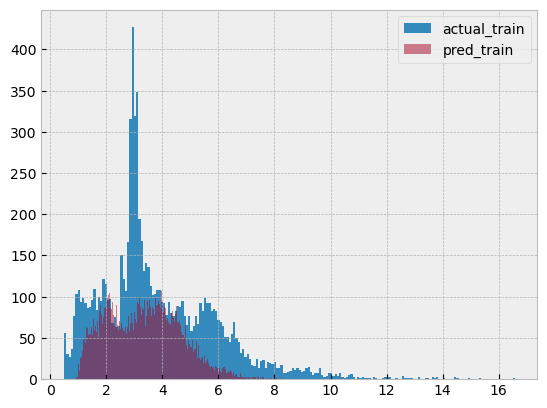

In [125]:
home_num = '246'
X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
pred = model.predict(X_train)
pred_home_train_single = pd.DataFrame({
                            "actual": np.exp(y_train)-0.01,
                            "pred": np.exp(pred)-0.01,
                            "home_num" : home_num})
plt.plot(pred_home_train_single["actual"], label="actual_train")
plt.plot(pred_home_train_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_train_single["actual"].values,pred_home_train_single["pred"].values) 
plt.show()

plt.hist(pred_home_train_single["actual"], label="actual_train", bins =200)
plt.hist(pred_home_train_single["pred"], label="pred_train",alpha =0.5, bins =200)
plt.legend()
plt.show()

In [126]:
nmae(pred_home_train_single["actual"], pred_home_train_single["pred"])

0.3806900937826805

## Model Prediction on Individual House Test

In [127]:
df_dict_test.keys()

dict_keys(['992', '319', '801', '640', '200', '441', '745', '945', '352', '683', '351', '318', '909', '977', '521', '842', '396', '601', '901', '238', '231', '889', '525', '130', '986', '462', '923', '925', '456', '624', '827', '474', '912', '194', '706', '522', '113', '247', '261'])

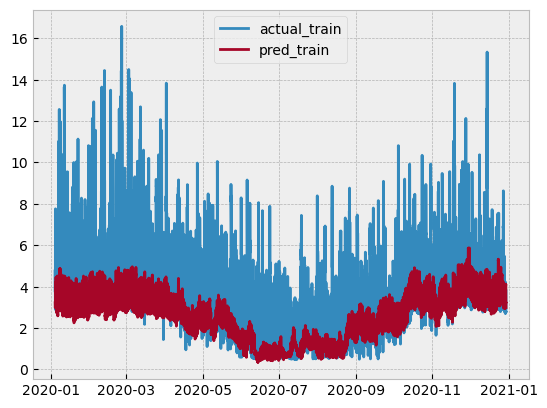

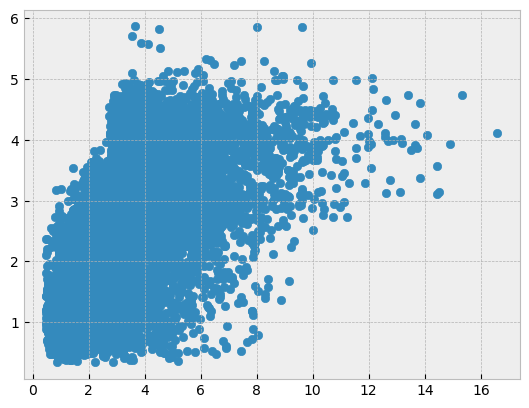

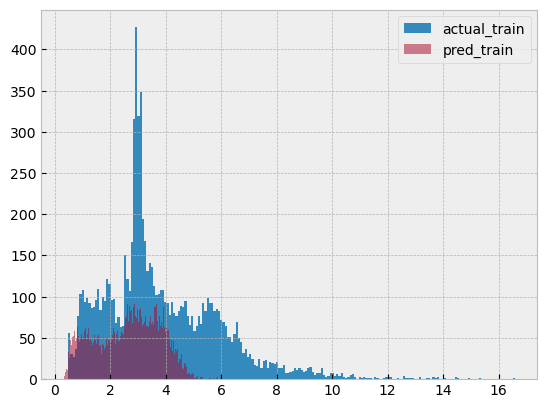

In [128]:
home_num = '319'
X_test, y_test = df_dict_test[home_num][FEATURES], df_dict_test[home_num][TARGET]
pred = model.predict(X_test)
pred_home_test_single = pd.DataFrame({
                            "actual": np.exp(y_train)-0.01,
                            "pred": np.exp(pred)-0.01,
                            "home_num" : home_num})
plt.plot(pred_home_test_single["actual"], label="actual_train")
plt.plot(pred_home_test_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_test_single["actual"].values,pred_home_test_single["pred"].values) 
plt.show()


plt.hist(pred_home_test_single["actual"], label="actual_train", bins = 200)
plt.hist(pred_home_test_single["pred"], label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [129]:
nmae(pred_home_test_single["actual"], pred_home_test_single["pred"])

0.5665275744167981

# Porfolio prediction on Train Data Set

In [130]:
pred_home_train = {}
for home_num in df_dict_train.keys():
    X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
    pred = model.predict(X_train)
    pred_home_train[home_num] = pd.DataFrame({
                                 "actual": np.exp(y_train)-0.01,
                                 "pred": np.exp(pred)-0.01,
                                 "home_num" : home_num})
    

In [131]:
portfolio_actual_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

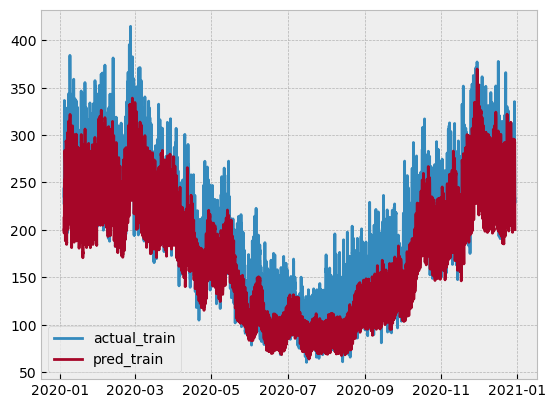

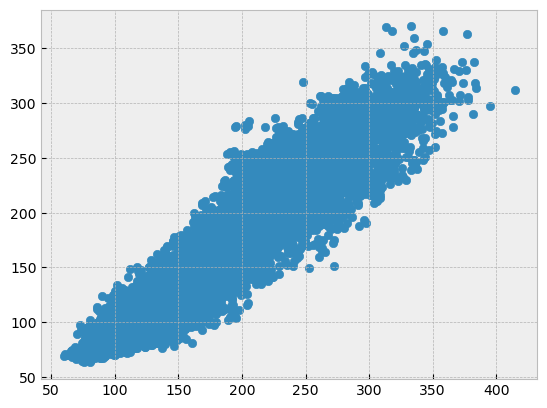

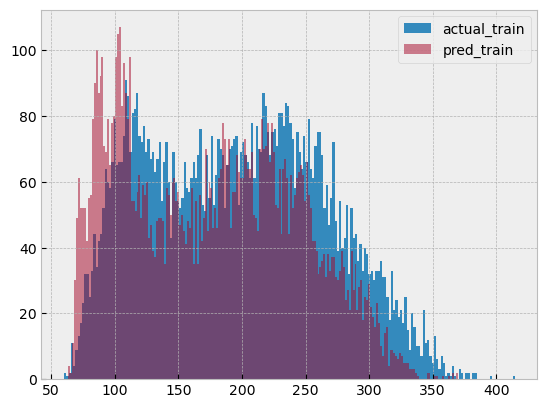

In [132]:
plt.plot(portfolio_actual_train, label="actual_train")
plt.plot(portfolio_pred_train, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_train, portfolio_pred_train)
plt.show()

plt.hist(portfolio_actual_train, label="actual_train", bins = 200)
plt.hist(portfolio_pred_train, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [133]:
nmae(portfolio_actual_train, portfolio_pred_train)

0.1426008676384874

# Porfolio prediction on Test Data Set

In [134]:
df_dict_test.keys()

dict_keys(['992', '319', '801', '640', '200', '441', '745', '945', '352', '683', '351', '318', '909', '977', '521', '842', '396', '601', '901', '238', '231', '889', '525', '130', '986', '462', '923', '925', '456', '624', '827', '474', '912', '194', '706', '522', '113', '247', '261'])

In [135]:
pred_home_test = {}
for home_num in df_dict_test.keys():
    X_test, y_test = df_dict_test[home_num][FEATURES], df_dict_test[home_num][TARGET]
    pred = model.predict(X_test)
    pred_home_test[home_num] = pd.DataFrame({
                                 "actual": y_test,
                                 "pred": pred,
                                 "home_num" : home_num})
    

In [136]:
portfolio_actual_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

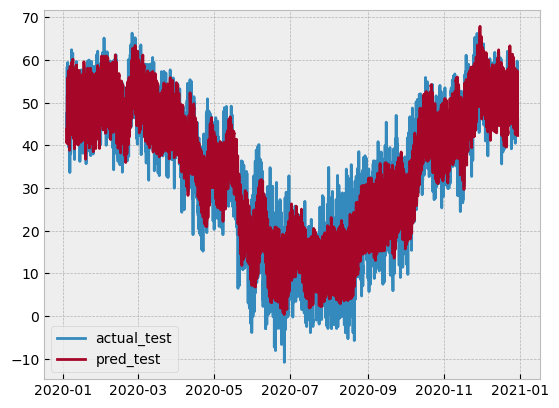

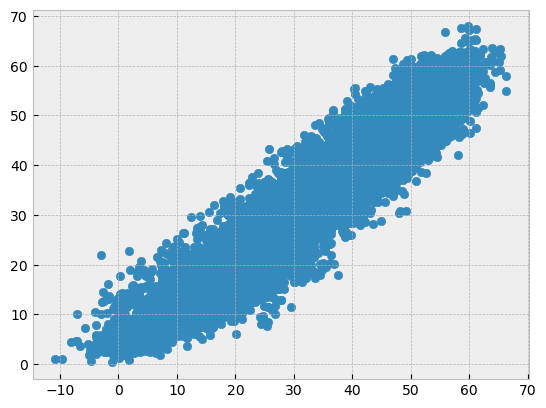

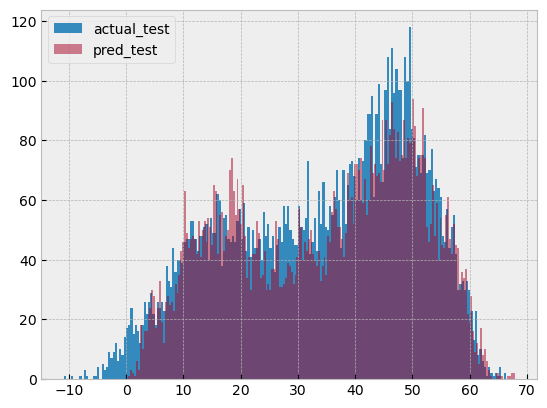

In [137]:
plt.plot(portfolio_actual_test, label="actual_test")
plt.plot(portfolio_pred_test, label="pred_test")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_test, portfolio_pred_test)
plt.show()


plt.hist(portfolio_actual_test, label="actual_test", bins = 200)
plt.hist(portfolio_pred_test, label="pred_test",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [138]:
nmae(portfolio_actual_test, portfolio_pred_test)

0.12210588604055707